[x[0]*x[1]*x[2] + x[0]*x[2]*x[3] + x[1]*x[2]*x[3] + x[1]*x[2] + x[1] + x[2]*x[3] + x[3] + 1, x[0]*x[1] + x[0]*x[2] + x[0]*x[3] + x[0] + x[1]*x[2]*x[3] + x[1]*x[3] + x[1] + x[3] + 1, x[0]*x[1]*x[2] + x[0]*x[1] + x[0]*x[2] + x[0]*x[3] + x[1] + x[2], x[0]*x[1]*x[3] + x[0]*x[1] + x[0]*x[3] + x[1]*x[3] + x[2]*x[3] + x[2]]


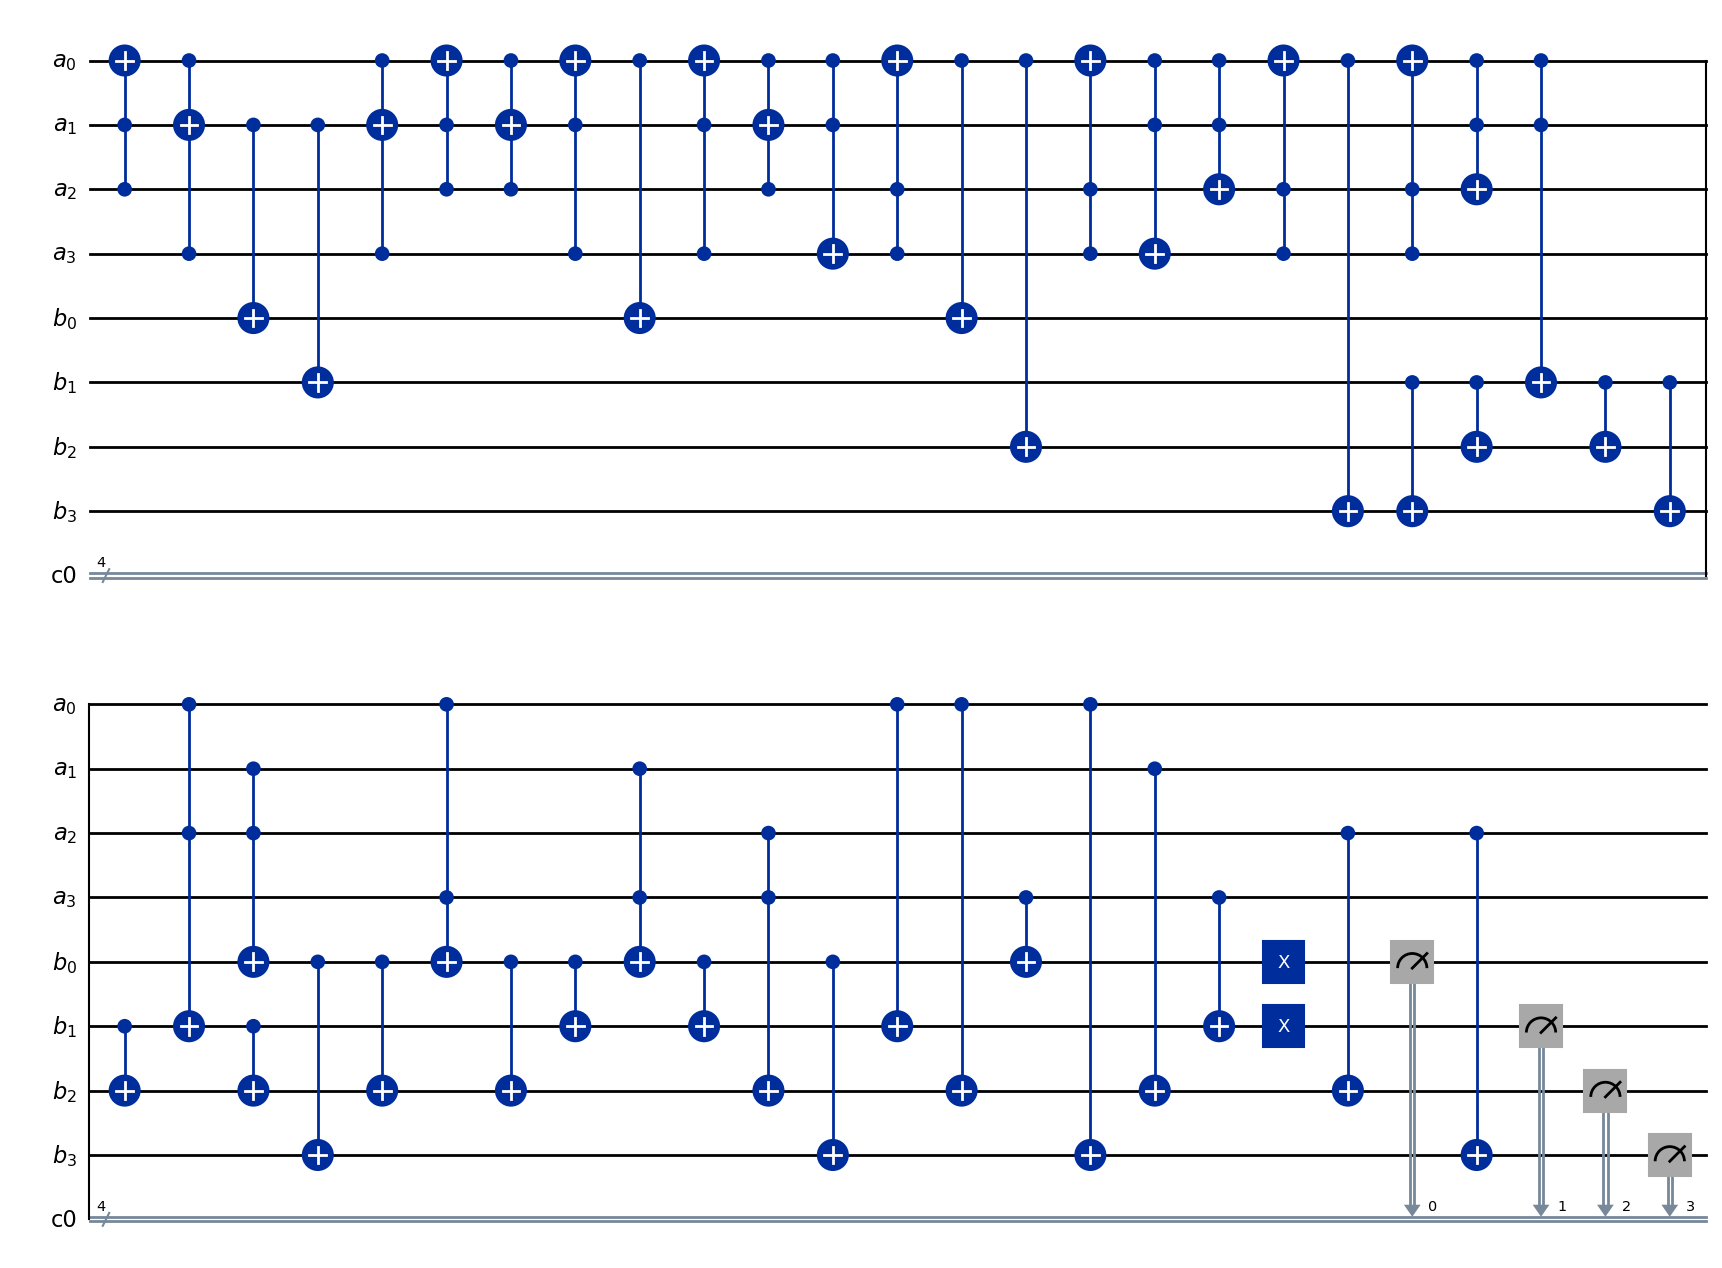

In [1]:
from sympy import * 
import math
###当可逆逻辑函数表示成一个字符串时，将其转换为多元布尔函数列表
def str_to_fun(str):
    n=len(str)
    lst=[]
    for i in range(0,n,2):
        lst.append(str[i:i+2])  #在列表的末尾添加一个元素
    len_lst=len(lst)   #计算数组的长度a
    len_bit=int(math.log(len_lst,2))  #计算输入S盒的位数  
    truth_table_input=[]      #先构建S盒的真值表
    truth_table_output=[]
    for i in range(len_lst):
        truth_table_input.append(bin(i)[2:].zfill(len_bit))  #将i转化为二进制并补足len_bit位，添加到真值表的输入中
        truth_table_output.append(bin(int(lst[i],16))[2:].zfill(len_bit))   #将sbox_arr中的每个元素转化为二进制并补足len_bit位，添加到真值表的输出中
    fun_expr=[]     #根据真值表构建代数表达式
    x= IndexedBase('x')  #定义数组符号变量x
    for i in range(len_bit):
        f=0
        for j in range(len_lst):
            item=1    #恒有2**len_bit-1个item为 1
            if truth_table_output[j][i]=='1':
                for k in range(len_bit):
                    if truth_table_input[j][k]=='0':
                        item*=(1+x[k])  #数值累乘并赋值
                    else:
                        item*=x[k]
            f+=item   #数值累加
        f=Poly(f, domain='GF(2)').args[0]   #将多项式做模2运算  
        fun_expr.append(f)
    return fun_expr





from sympy import * 
import math
import random
x= IndexedBase('x')
len_bit=32
lst_sub=[]
for i in range(len_bit):       #消去乘积后的二次项
    lst_sub.append((x[i]**2,x[i]))      #每个元组由两个元素组成
  

###定义在Toffoli门作用后多项式的变化
def toffoli_f(fun1,fun2,fun3):
    g=expand(fun3+fun1*fun2)  #展开表达式
    g=g.subs(lst_sub)      #使用元组来替换
    g=Poly(g, domain='GF(2)')
    return g.args[0]

###定义在CNOT门作用后多项式的变化
def cnot_f(fun1,fun2):
    g=expand(fun1+fun2)
    g=g.subs(lst_sub)
    g=Poly(g, domain='GF(2)')
    return g.args[0]

###定义求可逆逻辑函数(S盒)的最高次数
def degree_rev(f):
    len_f=len(f)      #求S盒的位数    
    degree=Poly(f[0]).total_degree()   #求出布尔函数的最高次数  
    for i in range(1,len_f):                
        if Poly(f[i]).total_degree() > degree:
            degree=Poly(f[i]).total_degree()
    return degree

###定义求多项式最高次项构成的集合
def high_degree_item(fun):
    degree=Poly(fun).total_degree()
    high_degree_item_set=set()
    for i in fun.args:
        if len(i.args)==degree:
            high_degree_item_set.add(i)
    return high_degree_item_set

###定义求可逆逻辑函数最高次项的集合
def high_item_rev(f):
    len_f=len(f)
    degree=degree_rev(f)
    high_item_set=set()    #由最高次数单项式构成的集合
    for i in range(len_f):
        for j in Poly(f[i]).args[0].args:
            if len(j.args)==degree:
                high_item_set.add(j)
    return high_item_set

###定义一个还原输入位的函数,从count_last位置到count_now位置逆向添加量子门
def gate_restore_lst(gate_lst,count_last,count_now):
    if count_last==-1:
        for i in gate_lst[count_now:0:-1]:
            gate_lst.append(i)
        gate_lst.append(gate_lst[0])
    else:
        for i in gate_lst[count_now:count_last:-1]:
            gate_lst.append(i)
    return gate_lst

###选择后续量子门函数的集合，在选择前，第一个控制位为前一个量子门的目标位
def choice_lst_k(len_bit,k):
    lst=[]
    for i in range(len_bit):
        for j in range(len_bit):
            if j!=i and j!=k and i!=k:
                lst.append([k,i,j])
    return lst



###定义二元域中求逆的函数
def inverse(A):
    A_inverse = np.linalg.inv(A)   #计算A的逆
    A_inverse = np.abs(A_inverse) %2   #取绝对值后模2
    A_inverse = A_inverse.astype(int)   
    return A_inverse

###搜索次数为可逆逻辑函数函数次数时，最高次项所在位置
def search_item_lst(fun,high_item_lst):
    lst=[]
    for i in range(len(high_item_lst)):
        lst.append(0)
    for i in fun.args:
        if i in high_item_lst:
            lst[high_item_lst.index(i)]=1
    return lst

###定义二元域中一个向量和矩阵的乘积
def multi_bA(b,A):    
    lst=[]
    for i in range(len(b)):
        sum=0
        for j in range(len(b)):
            sum=sum+b[j]*A[j][i]
        lst.append(sum % 2)
    return lst

###定义一个添加cnot门到可逆逻辑函数f的函数
def add_cnot(high_mat,high_index,f,gate_lst,high_item_lst,target_f,num_qubit):
    len_f=len(f)
    for i in range(len_f):
        fun_lst=search_item_lst(f[i],high_item_lst)
        solve_lst=multi_bA(fun_lst,inverse(high_mat))   
        for j in range(len(solve_lst)):
            if solve_lst[j]==1:
                gate_lst.insert(high_index[j]+1,[gate_lst[high_index[j]][2],num_qubit+i])                                   
                f[i]=cnot_f(target_f[high_index[j]],f[i])
                target_f.insert(high_index[j]+1,0) ###插入0元素占位
                for k in range(j+1,len(high_index)):
                    high_index[k]=high_index[k]+1
    return gate_lst,f

###定义一个消去重复Toffoli门的函数
def gate_lst_opt(gate_lst):
    gate_len=len(gate_lst)
    i=0
    while i<gate_len-1:
        if gate_lst[i]==gate_lst[i+1]:
            gate_lst.pop(i)   #移除并返回列表中的第一个元素
            gate_lst.pop(i)  #删除相邻的且相等的两个门
            gate_len=gate_len-2
            if (i-1)!=-1:
                i=i-1
        else:
            i=i+1   #消除后，先前判定无相邻且相等的门的结论失效
    return gate_lst

###定义一个统计量子资源的函数
def gate_lst_res(gate_lst):
    num_t,num_c,num_n=0,0,0
    for i in gate_lst:
        if len(i)==3:
            num_t=num_t+1
        elif len(i)==2:
            num_c=num_c+1
        else:
            num_n=num_n+1
    dict={'ccx':num_t,'cx':num_c,'x':num_n}
    return dict




from sympy import *  
import math
import random
x= IndexedBase('x')

### 定义一个实现单项式的函数,单项式的次数小于可逆逻辑函数的位数
def syn_mon(mon,num_qubit):
    gate_lst=[]    #存储量子门
    lst_cmp=[]     #存储多项式变量的补集
    lst_mon=list(mon.args)  #将单项式中的变量存储为列表   
    current_f=[]   #存储当前qubit的状态
    target_f=[]    #存储目标位上的函数值
    for i in range(num_qubit):
        current_f.append(x[i])  # 初始化当前可逆逻辑函数为变量
    lst_x=[]                    # 存储变量的列表
    for i in range(num_qubit):
        lst_x.append(x[i])
    for i in lst_x:
        if i not in lst_mon:
            lst_cmp.append(i)   #计算补集
    i,j=lst_x.index(lst_mon[0]),lst_x.index(lst_mon[1])
    k=lst_x.index(lst_cmp[0])
    lst_cmp.pop(0)   #因为后续会将其作为目标位
    gate_lst.append([i,j,k])
    current_f[k]=toffoli_f(current_f[i],current_f[j],current_f[k])
    target_f.append(current_f[k])
    lst_cmp.append(lst_mon[0])
    lst_cmp.append(lst_mon[1])
    lst_mon.pop(0) #删除第0个元素
    lst_mon.pop(0) #删除第1个元素   
    while lst_mon !=[]:   #当lst_mon非空时，执行循环体
        i,j,k=k,lst_x.index(lst_mon[0]),lst_x.index(lst_cmp[0])
        gate_lst.append([i,j,k])
        current_f[k]=toffoli_f(current_f[i],current_f[j],current_f[k])
        target_f.append(current_f[k])
        lst_cmp.append(lst_mon[0])
        lst_cmp.pop(0)
        lst_mon.pop(0)            
    return gate_lst,current_f,target_f





###将次数小于等于2的逻辑函数转化为实现的量子门列表
def syn_low(f,num_qubit):
    len_f=len(f)   
    x= IndexedBase('x')
    lst_x=[]
    for i in range(num_qubit):
        lst_x.append(x[i])
    lst=[]
    K=10000
    lst_K=[]
    for i in range(1,len_f):
        for j in range(i):
            for k in range(len_f):
                for l in f[k].args:
                    if l==x[i]*x[j]:
                        lst.append([j,i,k+num_qubit])
                        K=k
                        break
                if K!=10000:
                    break
            for k in range(K+1,len_f):
                for l in f[k].args:
                    if l==x[i]*x[j]:
                        lst_K.append(k)
            reversed_lst_K = lst_K[::-1]
            for i in reversed_lst_K:
                lst.insert(-1,[K+num_qubit,i+num_qubit])
            for i in lst_K:
                lst.append([K+num_qubit,i+num_qubit])
            lst_K.clear()
            K=10000
    for i in range(len_f):
        for j in range(len_f):
            for k in f[j].args:
                if k==x[i]:
                    lst.append([i,j+num_qubit])
    for i in range(len_f):
        for j in f[i].args:
            if j==1:
                lst.append([i+num_qubit])
    return lst





from sympy import * 
import math
import random
import copy
x= IndexedBase('x')

###定义从主函数没有回溯时的函数
def multi_step_syn(f,num_qubit):
    len_f=len(f)      #求S盒的位数    
    degree=degree_rev(f)   #求可逆逻辑函数的最高项次数
    gate_lst=[]          #用来存储量子门的数组
    while degree>2:
        high_item_set=high_item_rev(f)  #求出当前f的最高项的集合
        high_item_lst=list(high_item_set)  #将f的最高项的集合转换成列表
        for x in high_item_lst:
            lst,current_f,target_f=syn_mon(x,num_qubit)
            k=lst[-1][2]   #获取最后一个量子门的目标量子比特索引
            gate_lst.extend(lst)
            for i in range(len_f):
                if x in f[i].args:   #如果X是f[i]的一个参数
                    gate_lst.append([k,i+num_qubit])
                    f[i]=cnot_f(current_f[k],f[i])    #利用syn_mon的当前qubit状态结果,更新目标可逆逻辑函数。
            gate_lst.extend(reversed(lst))   #反向添加1st的量子门
        degree=degree_rev(f)                    
    lst2=syn_low(f,num_qubit)
    gate_lst.extend(lst2)
    gate_lst=gate_lst_opt(gate_lst)
    return gate_lst




import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
num_qubit=4
len_f=4
q1=QuantumRegister(num_qubit,'a')
q2=QuantumRegister(len_f,'b')
c1 = ClassicalRegister(len_f)

qc=QuantumCircuit(q1,q2,c1)

def lst_to_qc(lst,num_qubit):
    for lst1 in lst:
        if len(lst1)==3:
            if lst1[2]<num_qubit:
                qc.ccx(q1[lst1[0]],q1[lst1[1]],q1[lst1[2]])
            else:
                qc.ccx(q1[lst1[0]],q1[lst1[1]],q2[lst1[2]-num_qubit])
        elif len(lst1)==2:
            if lst1[1]<num_qubit:
                qc.cx(q1[lst1[0]],q1[lst1[1]])
            elif lst1[1]>=num_qubit and lst1[0]<num_qubit:
                qc.cx(q1[lst1[0]],q2[lst1[1]-num_qubit])
            else:
                qc.cx(q2[lst1[0]-num_qubit],q2[lst1[1]-num_qubit])
        else:
            qc.x(q2[lst1[0]-num_qubit])

##测试
# qc.x(q1[0])
# qc.x(q1[1])
# qc.x(q1[2])
# qc.x(q1[3])
# qc.x(q1[4])

##测试
s='0c000f0a020b090508030d07010e0604'
f=str_to_fun(s)
print(f)

lst=multi_step_syn(f,num_qubit)
lst_to_qc(lst,num_qubit)
for i in range(len_f):
    qc.measure(q2[i],c1[i])

qc.draw('mpl')

In [2]:
simulator = AerSimulator()
result = simulator.run(qc, shots=5, memory=True).result()
memory = result.get_memory(qc)
print(memory)
print(qc.count_ops())

['0011', '0011', '0011', '0011', '0011']
OrderedDict([('cx', 26), ('ccx', 22), ('measure', 4), ('x', 2)])


[x[0]*x[1]*x[2] + x[0]*x[2]*x[3] + x[1]*x[2]*x[3] + x[1]*x[2] + x[1] + x[2]*x[3] + x[3] + 1, x[0]*x[1] + x[0]*x[2] + x[0]*x[3] + x[0] + x[1]*x[2]*x[3] + x[1]*x[3] + x[1] + x[3] + 1, x[0]*x[1]*x[2] + x[0]*x[1] + x[0]*x[2] + x[0]*x[3] + x[1] + x[2], x[0]*x[1]*x[3] + x[0]*x[1] + x[0]*x[3] + x[1]*x[3] + x[2]*x[3] + x[2]]
[[1, 2, 0], [0, 3, 1], [1, 5], [1, 2, 3], [3, 6], [3, 0, 1], [1, 6], [1, 4], [3, 0, 1], [1, 2, 3], [0, 3, 1], [1, 2, 0], [0, 1, 2], [2, 3, 0], [0, 7], [2, 3, 0], [0, 1, 2], [5, 7], [5, 6], [0, 1, 5], [5, 6], [5, 7], [5, 6], [0, 2, 5], [5, 6], [6, 7], [0, 3, 6], [6, 7], [5, 7], [1, 3, 5], [5, 7], [2, 3, 4], [0, 5], [0, 7], [2, 6], [2, 7], [3, 4], [3, 5], [3, 6], [4], [5]]


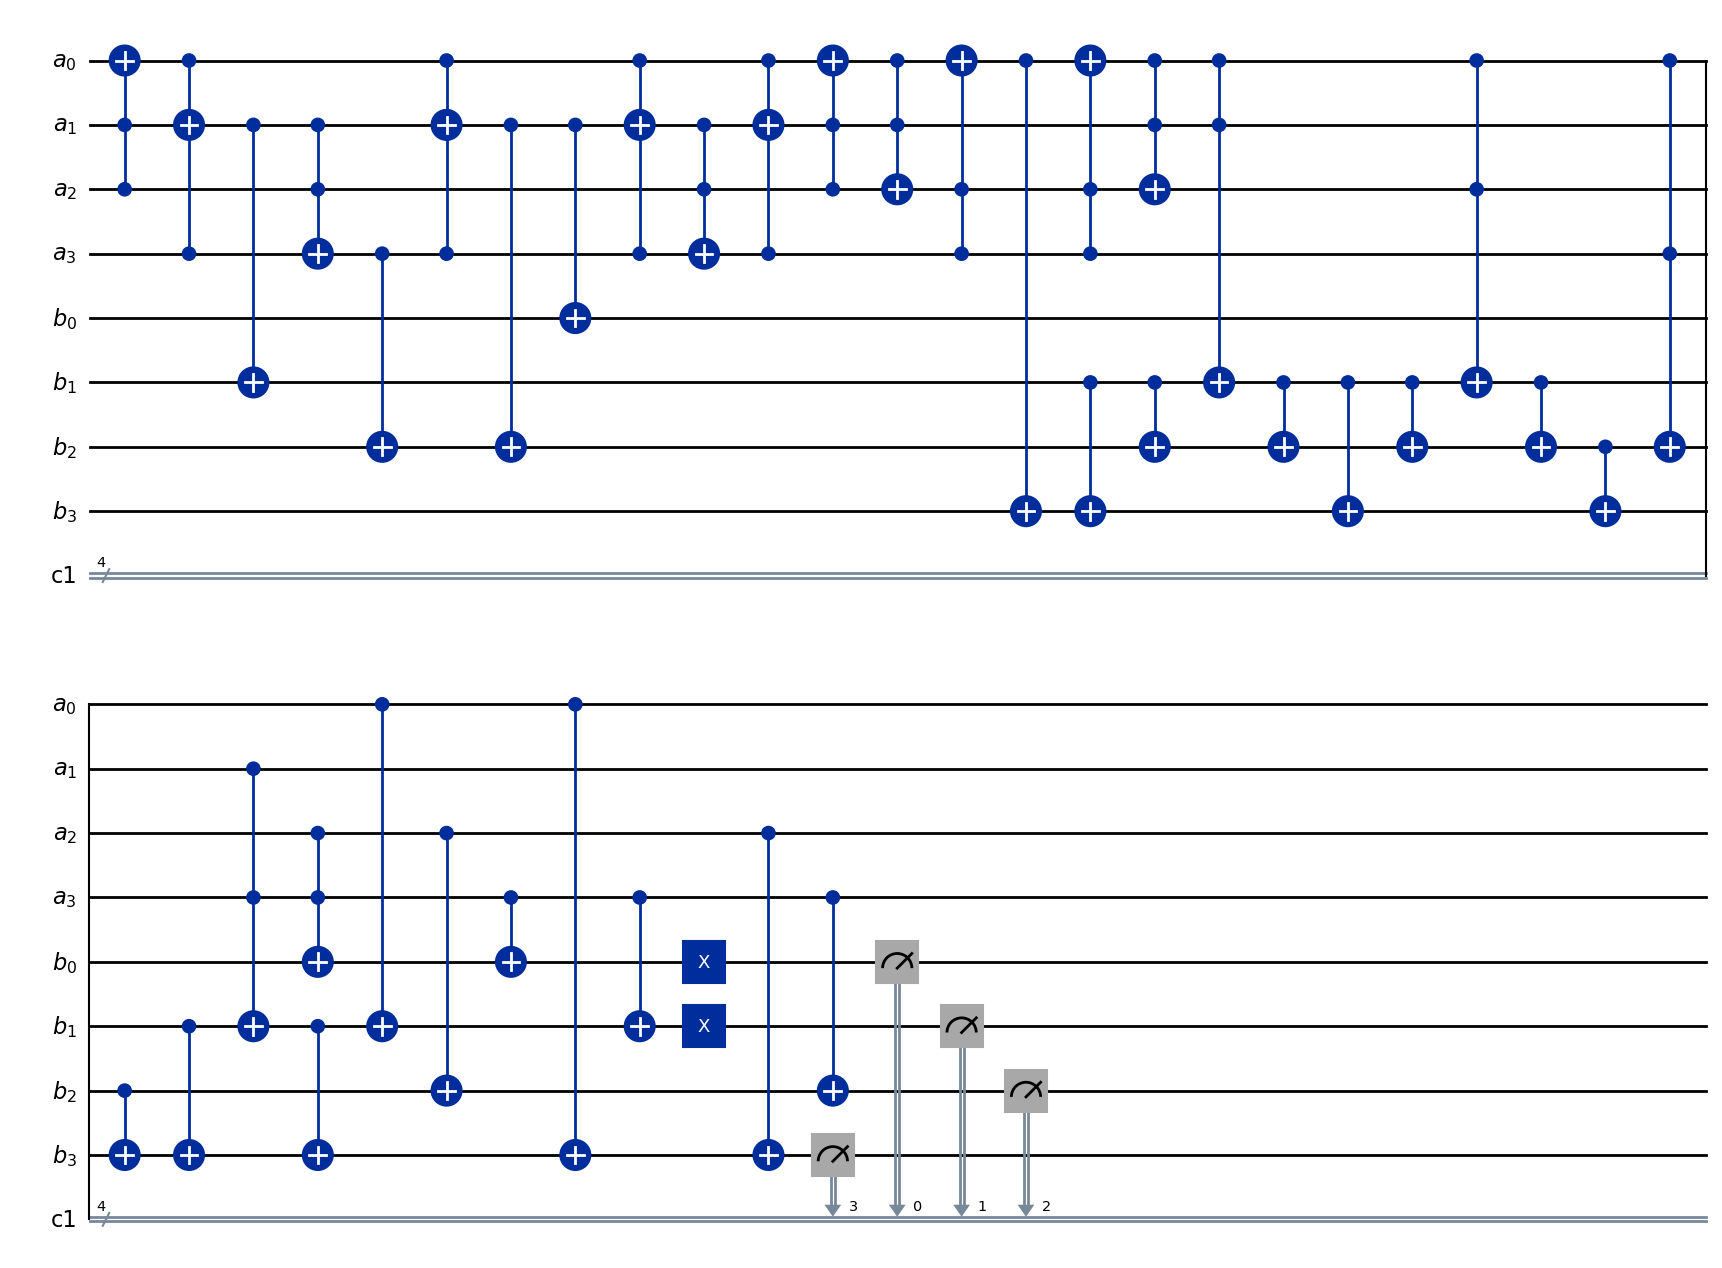

In [3]:
###定义一个估价函数，评估候选的i,j,k的值，为下一次选择做准备
def eval_fun(i,j,k,current_f,current_item_set,high_item_set,num_qubit,degree):
    len_f=len(current_f)
    m=math.factorial(num_qubit)          #定义一个最大值，当i,j,k满足可添加的条件时赋该值，而且其他情况不能达到该值
    fun=toffoli_f(current_f[i],current_f[j],current_f[k])
    degree_fun=Poly(fun).total_degree()   #计算fun的次数
    
    if degree_fun>degree:
        return 0      #最高项次数大于要消去的次数时，不能选择
    elif degree_fun==degree:
        s=high_degree_item(fun)    #计算最高次数项
        if degree_fun==degree and (len(s.difference(current_item_set))==1) and (s.issubset(high_item_set)):   
            return m    #检查集合 s和 current_item_set 之间的差集的长度是否等于 1。检查集合 s是否是集合 high_item_set 的子集
        else:
            return 0       #最高次项和要消去的项的次数相等，但是不满足条件，不选择（当然可能有漏选）
    else:
        s=high_degree_item(fun) 
        sum=0
        for i in s:
            for j in high_item_set:
                if set(i.args).issubset(set(j.args)):   #先将i,j的各个子项提取出来，再转化为集合，再比较是不是子集。
                    sum=sum+len(i.args)**2
        return sum




from sympy import * 
import math
import random
import copy
x= IndexedBase('x')

###定义一个将次数大于3的可逆函数消去最高次项的函数
def elim_onedegree(f,num_qubit):
    len_f=len(f)      #求逻辑函数的分量数    
    m=math.factorial(num_qubit)      #估价函数最大值，即满足添加条件时的估价函数的值
    degree=degree_rev(f)   #求可逆逻辑函数的最高项次数
    gate_lst=[]          #用来存储量子门的数组
    high_index=[]      #当产生的有可逆逻辑函数分量的最高次项为可逆函数的项数时，存储该量子门在门列表中的位置    
    high_mat=[]        #用来存储最高次项多项式产生的可逆矩阵
    target_f=[]        #存储目标位中的函数
    current_item_set=set()   #用来存储当前已经构建的最高次项
    high_item_set=high_item_rev(f)  #求出当前f的最高项的集合   
    high_item_lst=list(high_item_set)  #将f的最高项的集合转换成列表   
    len_high=len(high_item_set)                    #求逻辑函数中最高次项元素的个数
    
    x=high_item_lst[0]
    lst,current_f,target_f=syn_mon(x,num_qubit)    
    current_item_set.add(x)
    gate_lst.extend(lst)    
    high_mat.append(search_item_lst(x+1,high_item_lst))  #search_item_lst的第一个参数是多项式，x+1让其变成多项式   
    count_last=-1    #用来记录还原前量子门的前一个位置   
    count_now=degree-2   #用来记录最后一个门的位置
    high_index.append(count_now)
    k=gate_lst[-1][2]
            
    while True:   
        choice_lst=choice_lst_k(num_qubit,k)  #将量子门的可选集添加进choice_lst列表
        max_val=0   #记录最大估价值，初始化为最小值0
        t=len(gate_lst)   
        if t<num_qubit:
            win_lst=gate_lst
        else:
            win_lst=gate_lst[t-num_qubit:t]  #创建一个滑动窗口，防止进入死循环    
        for lst in choice_lst:          #寻找估价函数值最大的i,j,k
            if lst in win_lst:
                val=0
            else:   #进行估价
                val=eval_fun(lst[0],lst[1],lst[2],current_f,current_item_set,high_item_set,num_qubit,degree)
            if val>max_val:
                max_val=val   #更新
                max_ijk=lst   #量子门组合
            if max_val==m:
                break
        if max_val==m:   
            gate_lst.append(max_ijk)
            count_now=count_now+1     #门的位置+1
            i,j,k=max_ijk[0],max_ijk[1],max_ijk[2]
            current_f[k]=toffoli_f(current_f[i],current_f[j],current_f[k])   #应用新的Toffoli门
            target_f.append(current_f[k])
            high_mat.append(search_item_lst(current_f[k],high_item_lst))
            high_index.append(count_now)     #将目前的位置加入到高价项索引列表当中
            current_item_set=current_item_set.union(high_degree_item(current_f[k]))   #集合取并集
            if len(current_item_set)==len_high:    #检查所有最高次项是否都已经构建好了
                gate_lst=gate_restore_lst(gate_lst,count_last,count_now)
                gate_lst,f=add_cnot(high_mat,high_index,f,gate_lst,high_item_lst,target_f,num_qubit)
                gate_lst=gate_lst_opt(gate_lst)      #消去重复的门
                return gate_lst,f             #有解返回
        elif max_val==0:     #已经不能扩展了
            gate_lst=gate_restore_lst(gate_lst,count_last,count_now)       #还原    
            for i in range(count_now-count_last):
                target_f.append(0)   #添加0占位，使得target_f中的元素和gate_lst里的元素对应
            count_now=2*count_now-count_last   #加上添加的门数
            count_last=count_now    #下次还原的起点
            x=list(high_item_set.difference(current_item_set))[0] #取还没有实现的一个最高次项，准备实现并扩展
            current_item_set.add(x)      #下面会实现x，所以将它添加进目前已实现的最高次项集合
            lst2,current_f,target_f2=syn_mon(x,num_qubit)  #current_f是新的值，门集和目标函数值需要添加到以前的列表中   
            gate_lst.extend(lst2)    ##lst2的次数将不断降低
            target_f.extend(target_f2)
            count_now=count_now+degree-1
            high_mat.append(search_item_lst(x+1,high_item_lst))  #search_item_lst的第一个参数是多项式，x是单项式，x+1让其变成多项式
            high_index.append(count_now)
            if len(current_item_set)==len_high:     #若已经实现的个数与目标数量一致
                gate_lst=gate_restore_lst(gate_lst,count_last,count_now)
                gate_lst,f=add_cnot(high_mat,high_index,f,gate_lst,high_item_lst,target_f,num_qubit)
                gate_lst=gate_lst_opt(gate_lst) #消去重复的门
                return gate_lst,f             #有解返回
        else:
            gate_lst.append(max_ijk)
            count_now=count_now+1
            i,j,k=max_ijk[0],max_ijk[1],max_ijk[2]
            current_f[k]=toffoli_f(current_f[i],current_f[j],current_f[k])
            target_f.append(current_f[k])




from sympy import * 
import math
import random
import copy
x= IndexedBase('x')

###定义从主函数没有回溯时的函数
def multi_step_syn_opt(f,num_qubit):  
    degree=degree_rev(f)   #求可逆逻辑函数的最高项次数
    gate_lst=[]          #用来存储量子门的数组
    while degree>2:
        lst,f=elim_onedegree(f,num_qubit)
        gate_lst.extend(lst)
        degree=degree_rev(f)
    lst2=syn_low(f,num_qubit)
    gate_lst.extend(lst2)
    gate_lst=gate_lst_opt(gate_lst)
    return gate_lst





import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
num_qubit=4
len_f=4
q1=QuantumRegister(num_qubit,'a')
q2=QuantumRegister(len_f,'b')
c1 = ClassicalRegister(len_f)

qc=QuantumCircuit(q1,q2,c1)




##测试
# qc.x(q1[0])
# qc.x(q1[1])
# qc.x(q1[2])
# qc.x(q1[3])
# qc.x(q1[4])

s='0c000f0a020b090508030d07010e0604'  
f=str_to_fun(s)
print(f)

lst=multi_step_syn_opt(f,num_qubit)
print(lst)

lst_to_qc(lst,num_qubit)
for i in range(len_f):
    qc.measure(q2[i],c1[i])

qc.draw('mpl')

In [4]:
simulator = AerSimulator()
result = simulator.run(qc, shots=5, memory=True).result()
memory = result.get_memory(qc)
print(memory)
print(qc.count_ops())

['0011', '0011', '0011', '0011', '0011']
OrderedDict([('cx', 22), ('ccx', 17), ('measure', 4), ('x', 2)])
